In [1]:
import pandas as pd
import numpy as np
from fine_food_review import FineFoodReview
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FFR = FineFoodReview()
df = FFR.dataset

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
FFR.grouped_by_user

UserId
A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A2HROKQO0GA5AF      1
A2HROR28DMJV2W      1
A2HRR8CO2Y20G8      1
A2HRSML93IK9TR      1
AZZZOVIBXHGDR       1
Length: 256059, dtype: int64

In [7]:
FFR.grouped_by_product

ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWHJOU    632
B002QWP89S    632
B002QWP8H0    632
             ... 
B000YPQC08      1
B003YU5T6I      1
B000YPQC44      1
B000YPQE6U      1
B009WVB40S      1
Length: 74258, dtype: int64

In [8]:
print("Number of unique users:", FFR.grouped_by_user.size)
print("Number of unique products:", FFR.grouped_by_product.size)

Number of unique users: 256059
Number of unique products: 74258


In [9]:

print("User Reviews Statistics:")
display(FFR.stats["user"])

print("Product Reviews Statistics:")
display(FFR.stats["product"])

User Reviews Statistics:


{'count': 256059.0,
 'mean': 2.2200117941568154,
 'std': 4.443360696402324,
 'min': 1.0,
 '25%': 1.0,
 '50%': 1.0,
 '75%': 2.0,
 'max': 448.0}

Product Reviews Statistics:


{'count': 74258.0,
 'mean': 7.655121333728353,
 'std': 26.453484529703807,
 'min': 1.0,
 '25%': 1.0,
 '50%': 2.0,
 '75%': 5.0,
 'max': 913.0}

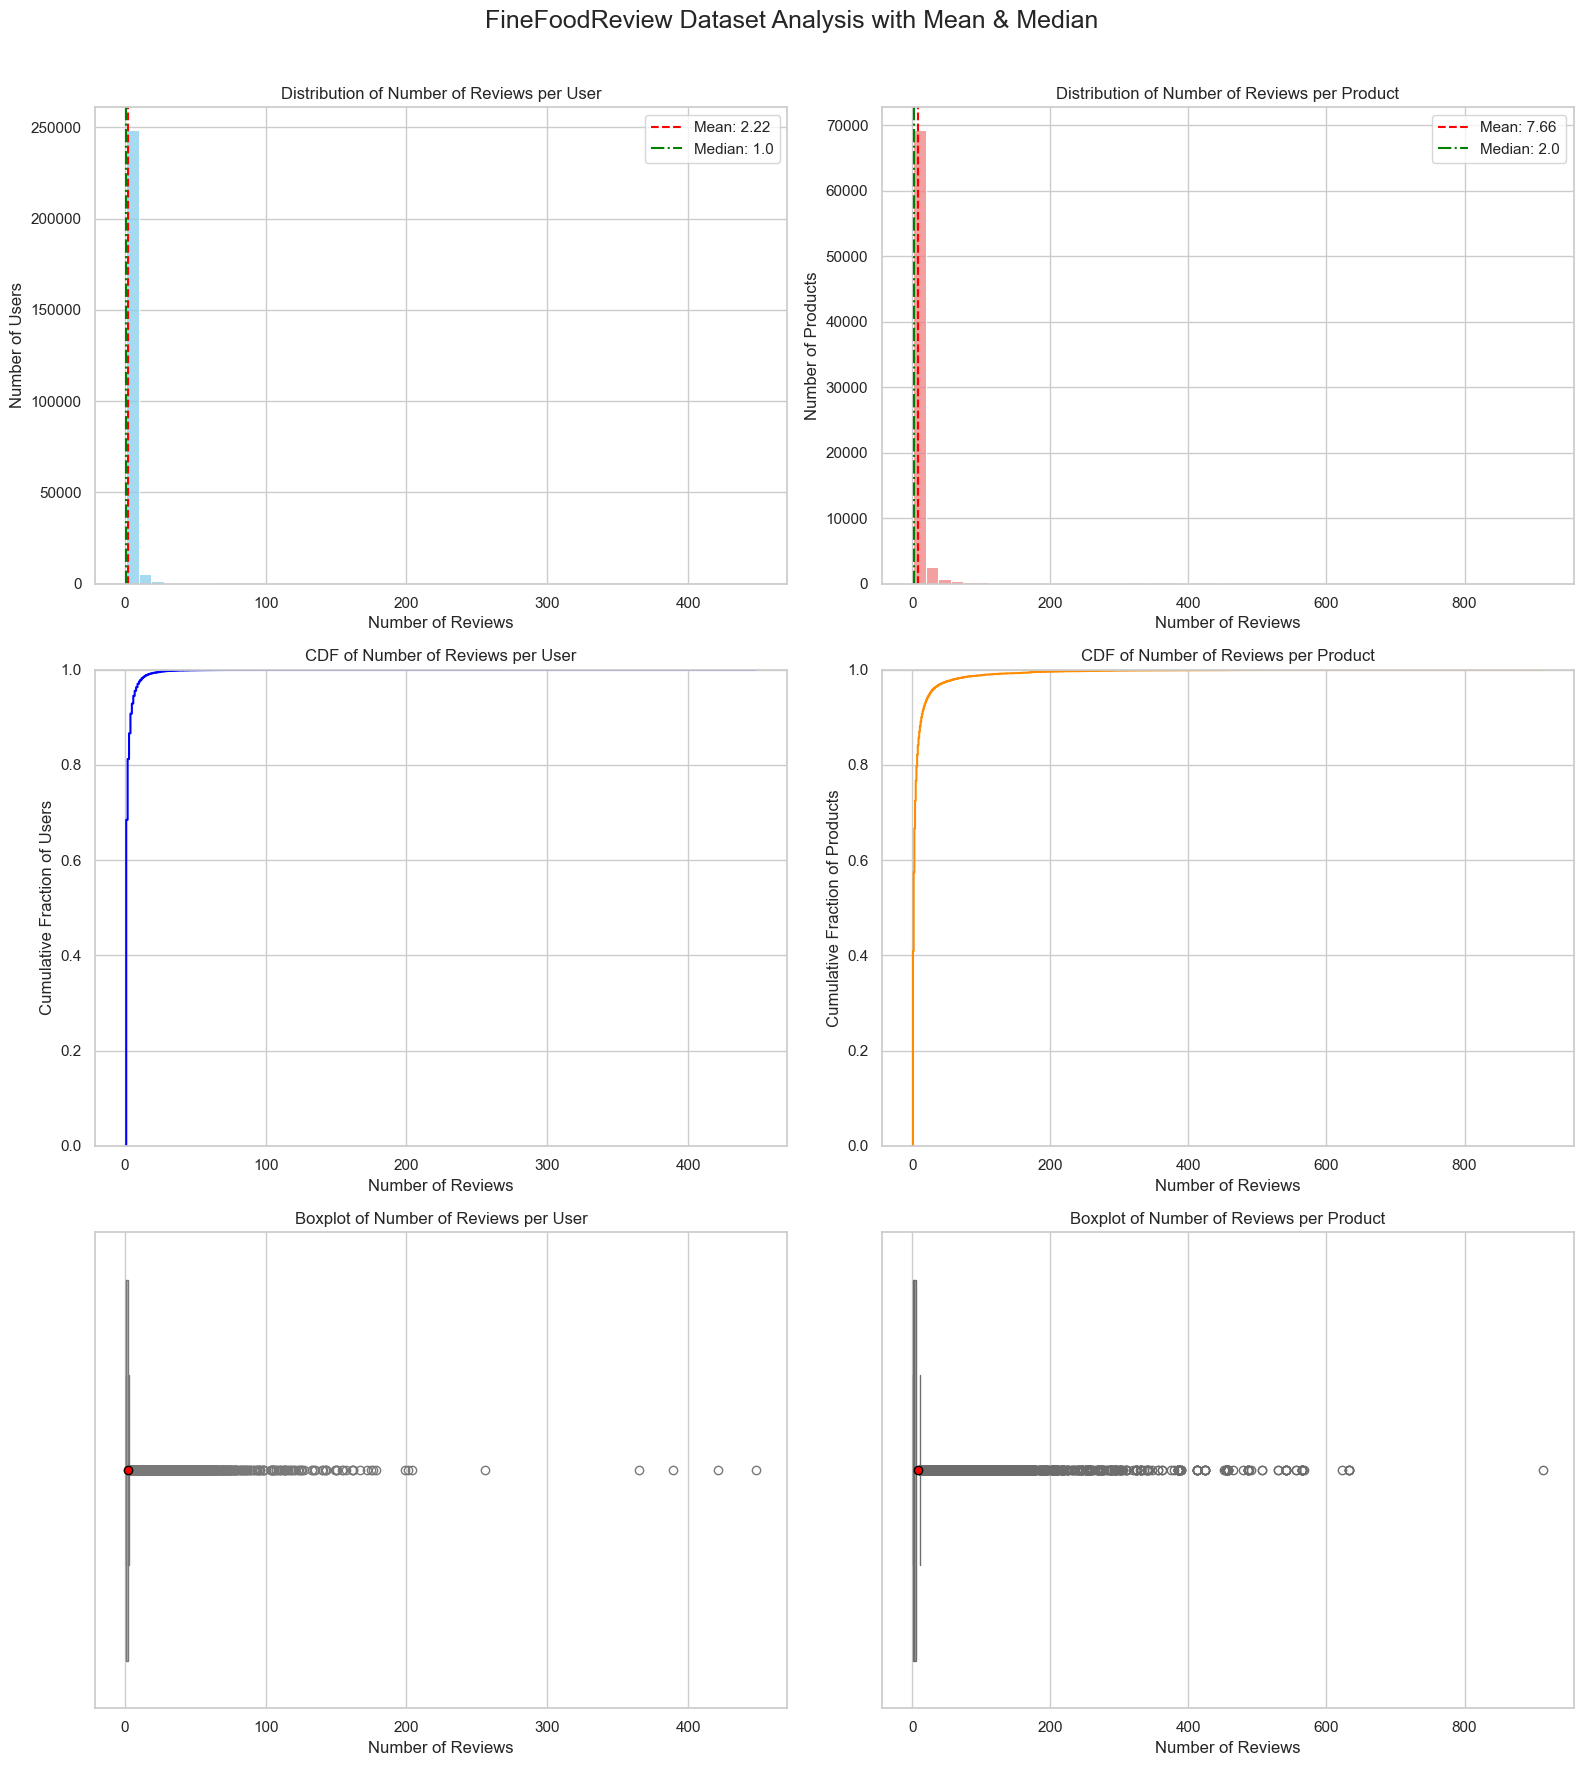

In [27]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("FineFoodReview Dataset Analysis with Mean & Median", fontsize=18)

# 1. Histogram of reviews per user
mean_u = FFR.grouped_by_user.mean()
median_u = FFR.grouped_by_user.median()
sns.histplot(FFR.grouped_by_user.to_numpy(), bins=50, ax=axes[0,0], color="skyblue", kde=False)
axes[0,0].axvline(mean_u, color="red", linestyle="--", label=f"Mean: {mean_u:.2f}")
axes[0,0].axvline(median_u, color="green", linestyle="-.", label=f"Median: {median_u}")
axes[0,0].set_title("Distribution of Number of Reviews per User")
axes[0,0].set_xlabel("Number of Reviews")
axes[0,0].set_ylabel("Number of Users")
axes[0,0].legend()

# 2. Histogram of reviews per product
mean_p = FFR.grouped_by_product.mean()
median_p = FFR.grouped_by_product.median()
sns.histplot(FFR.grouped_by_product.to_numpy(), bins=50, ax=axes[0,1], color="lightcoral", kde=False)
axes[0,1].axvline(mean_p, color="red", linestyle="--", label=f"Mean: {mean_p:.2f}")
axes[0,1].axvline(median_p, color="green", linestyle="-.", label=f"Median: {median_p}")
axes[0,1].set_title("Distribution of Number of Reviews per Product")
axes[0,1].set_xlabel("Number of Reviews")
axes[0,1].set_ylabel("Number of Products")
axes[0,1].legend()

# 3. CDF for users
sns.ecdfplot(FFR.grouped_by_user.to_numpy(), ax=axes[1,0], color="blue")
axes[1,0].set_title("CDF of Number of Reviews per User")
axes[1,0].set_xlabel("Number of Reviews")
axes[1,0].set_ylabel("Cumulative Fraction of Users")
axes[1,0].grid(True)


# 4. CDF for products
sns.ecdfplot(FFR.grouped_by_product.to_numpy(), ax=axes[1,1], color="darkorange")
axes[1,1].set_title("CDF of Number of Reviews per Product")
axes[1,1].set_xlabel("Number of Reviews")
axes[1,1].set_ylabel("Cumulative Fraction of Products")
axes[1,1].grid(True)

# 5. Boxplot for users
sns.boxplot(x=FFR.grouped_by_user, ax=axes[2,0], color="lightblue", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,0].set_title("Boxplot of Number of Reviews per User")
axes[2,0].set_xlabel("Number of Reviews")

# 6. Boxplot for products
sns.boxplot(x=FFR.grouped_by_product, ax=axes[2,1], color="salmon", showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"red","markeredgecolor":"black"})
axes[2,1].set_title("Boxplot of Number of Reviews per Product")
axes[2,1].set_xlabel("Number of Reviews")

plt.tight_layout(rect=(0, 0, 1, 0.97))
plt.show()




From the user and product statistics, we can see that the average number of reviews per user is around 2.22, with a maximum of 448 reviews by a single user. For products, the average number of reviews is about 7.66, with a maximum of 913 reviews for a single product. This indicates that while most users review only a few products, some users are very active in reviewing multiple products. Also, looking at the 75%, we can see that 75% of users have reviewed 2 or fewer products, and 75% of products have received 5 or fewer reviews. This suggests a long tail distribution where a few users and products are highly active while the majority are not. It's important to consider these statistics when training models, as they can impact the model's ability to generalize and the importance of certain users or products in the dataset. 


In [28]:
df[df['HelpfulnessDenominator'] != df['HelpfulnessNumerator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
15,16,B001GVISJM,A1CZX3CP8IKQIJ,Brian A. Lee,4,5,5,1262044800,"Lots of twizzlers, just what you expect.",My daughter loves twizzlers and this shipment ...
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan..."
27,28,B001GVISJM,AAAS38B98HMIK,Heather Dube,0,1,4,1331856000,Great Bargain for the Price,I was so glad Amazon carried these batteries. ...
31,32,B003F6UO7K,A31OQO709M20Y7,"Molly V. Smith ""staral""",0,1,5,1288310400,THIS IS MY TASTE...,"This offer is a great price and a great taste,..."
...,...,...,...,...,...,...,...,...,...,...
568405,568406,B000P56I7Y,A2ZKNGL20FBK2I,Shatzi Crabtree,3,5,5,1274918400,Arrived Fine,The product arrived pretty quickly and was eas...
568413,568414,B0018CLWM4,AI3Y26HLPYW4L,kimosabe,1,2,2,1330041600,premium edge cat food,My cats don't like it. what else can I say to ...
568417,568418,B0000D16IP,A1SOL9F0I9D3A4,William M. Jacobs,2,4,4,1257897600,Great,This is the best brand of Mango Chutney that I...
568435,568436,B003XUL27E,A2PSB4WQHH46HN,carlyowu,0,2,2,1285718400,Where's the tortellini?,"It is mostly broth, with the advertised 3/4 cu..."
